## Import modules

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/Gabriels_experiments_STED/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

In [23]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Soma mask from synapse channel":[],
           "Neurites mask from synapse channel":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],
           "ECM raw intensity, unmasked":[],
           "Nuclei raw intensity, unmasked":[],
           "Synapse raw intensity, unmasked":[],
           "ECM intensity: unmasked, divded by unblocked condition":[],
           "ECM mean intensity: soma only":[],
           "ECM mean intensity: soma only, divided by unblocked":[],
           "ECM mean intensity: neurites only":[],
           "ECM mean intensity: neurites only, divided by unblocked":[],
           "ECM mean intensity: matlab manual mask only":[],
           "ECM mean intensity: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity: soma only":[],
           "Synapse mean intensity: neurites only":[],
           "Synapse mean intensity: matlab manual mask only":[],
           "Nuclei mean intensity: soma only":[],
           "Nuclei mean intensity: neurites only":[],
           "Nuclei mean intensity: matlab manual mask only":[],
           "Number of synapse spots in soma mask":[],
           "Number of synapse spots in neurites mask":[],
           "Number of synapse spots in matlab manual mask":[],
           "Number of nuclei spots in soma mask":[],
           "Number of nuclei spots in neurites mask":[],
           "Number of nuclei spots in matlab manual mask":[],
           "ECM mean intensity after bg subtraction: soma only":[],
           "ECM mean intensity after bg subtraction: soma only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: neurites only":[],
           "ECM mean intensity after bg subtraction: neurites only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity after bg subtraction: soma only":[],
           "Synapse mean intensity after bg subtraction: neurites only":[],
           "Synapse mean intensity after bg subtraction: matlab manual mask only":[],
           "Number of synapse spots in soma mask after bg subtraction":[],
           "Number of synapse spots in neurites mask after bg subtraction":[],
           "Number of synapse spots in matlab manual mask after bg subtraction":[],
           "Number of nuclei spots in soma mask after bg subtraction":[],
           "Number of nuclei spots in neurites mask after bg subtraction":[],
           "Number of nuclei spots in matlab manual mask after bg subtraction":[],
          "Number of nuclei spots in matlab manual mask after bg subtraction":[],
          "Manual synapse spots mask":[]}
          
histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

independent_ecm_results={"filename":[],
                     "exp condition":[],
                     "regionprops auto masking":[],
                     "regionprops matlab mask":[],
                        "distance from nearest dapi border":[]}

ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[]
                                 }

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if ("Focus" in str(filelist[i]))==False:
            if (protein in str(filelist[i]))==True:
                if filelist[i].endswith(".tif"): 
                    if str(filelist[i][:-12]) not in str(results["filename"]):

                        results["filename"].append(filelist[i][:-12])
                        histogram_results["filename"].append(filelist[i][:-12])
                        regionprops_results["filename"].append(filelist[i][:-12])
                        independent_ecm_results["filename"].append(filelist[i][:-12])

                        results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        histogram_results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        regionprops_results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        independent_ecm_results["exp condition"].append(filelist[i][:-12].split('/')[-2])
             
                        channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                        exec(open(channeldir+"/channels.txt").read())
                        results["ecmchannelno"].append(ecmchannelno)
                        results["nucleichannelno"].append(nucleichannelno)
                        results["synapsechannelno"].append(synapsechannelno)
                        positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                        if positivecontrolcheck.exists():
                            results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

<a id='loadingprocessinganalysing'></a> 
## Loading, processing and batch analyzing the images
**Let's start by loading a random image and looking at the ECM channel:**

Image name: 06_005_ExpControl
Experimental condition: 4hrs_Bic


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text yticklabel objects>)

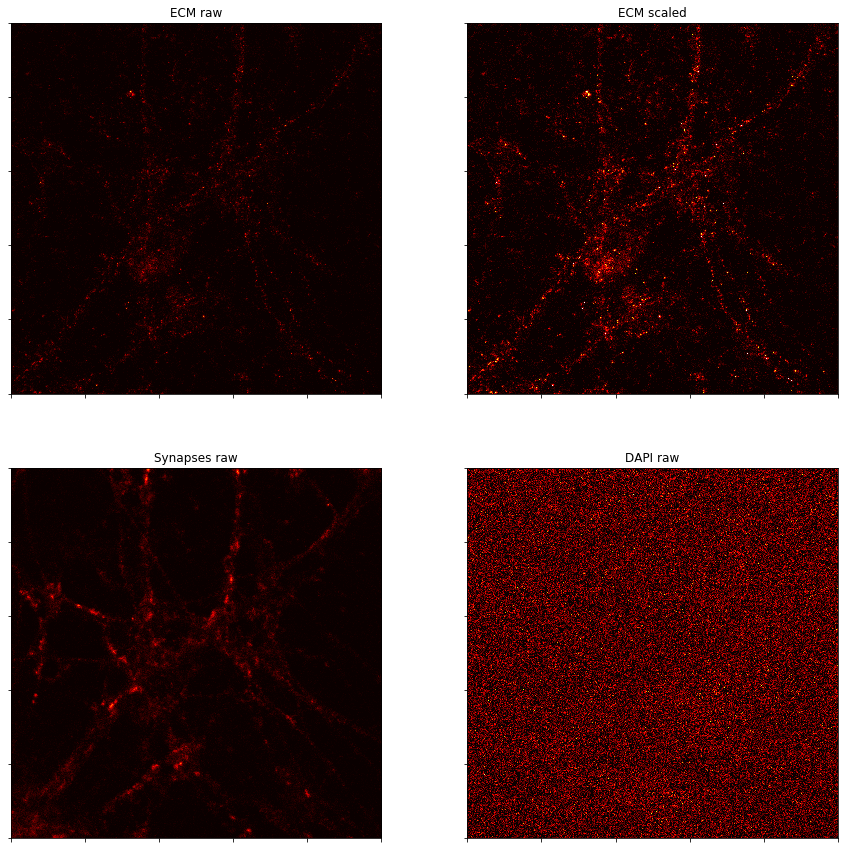

In [20]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
nuclei_image_name=results["filename"][randomno]+" Ch"+str(nuclei_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
nuclei_image=pims.open(nuclei_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(222)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(223)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(224)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)



In [26]:
for i in range(0,len(results["filename"])):
    results["Manual synapse spots mask"].append(np.nan)

### Find synapse spots

In [34]:
import ipywidgets as widgets
from ipywidgets import interact

#load first image
synapse_channel_no=results["synapsechannelno"][0]
synapse_image_name=results["filename"][0]+" Ch"+str(synapse_channel_no)+" {0}.tif"
synapse_image=pims.open(synapse_image_name)[0]
synapse_spots=deepcopy(synapse_image)
lower_man_threshold=np.min(synapse_spots)
upper_man_threshold=np.max(synapse_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    synapse_channel_no=results["synapsechannelno"][ii]
    synapse_image_name=results["filename"][ii]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    synapse_spots=deepcopy(synapse_image)
    lower_man_threshold=np.min(synapse_spots)
    upper_man_threshold=np.max(synapse_spots)

    if Threshold=="Li":
        synapse_image_threshold=threshold_li(synapse_image)      
    if Threshold=="Otsu":
        synapse_image_threshold=threshold_otsu(synapse_image)
    if Threshold=="Manual":
        synapse_image_threshold=Manual_Threshold
    
    synapse_spots[synapse_spots<synapse_image_threshold]=0
    synapse_spots=ndi.binary_opening(synapse_spots,iterations=Open)
    synapse_spots=ndi.binary_closing(synapse_spots,iterations=Close)
    results["Manual synapse spots mask"][ii]=synapse_spots
    plt.figure(figsize=(10,10))
    plt.imshow(synapse_spots)
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)




interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

Text(0.5,1,'ECM raw image')

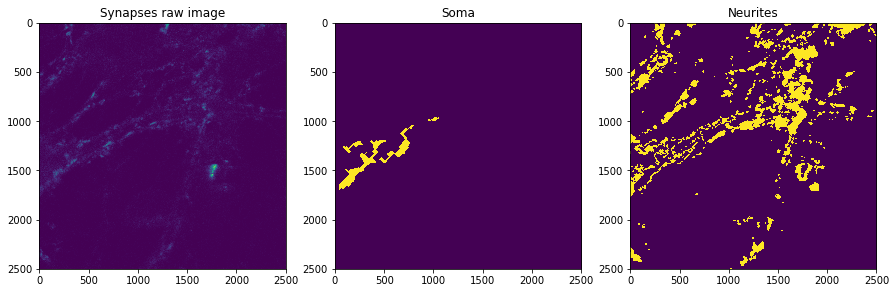

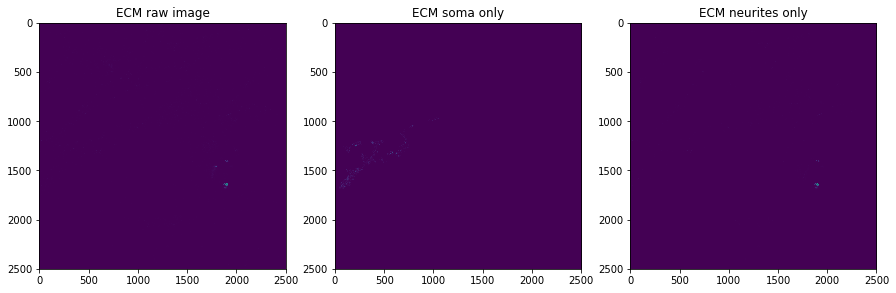

In [45]:
ecm_image_threshold=threshold_li(ecm_image)
ecm_image_thresholded=deepcopy(ecm_image)
ecm_image_thresholded[ecm_image_thresholded<ecm_image_threshold]=0



def makemask(synapse_image):
    #li thresholding
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    #find soma + some morphological operations
    synapse_labeled_mask, cc_num = ndi.label(synapse_image_thresholded)
    synapse_largest_cc_mask = (synapse_labeled_mask == (np.bincount(synapse_labeled_mask.flat)[1:].argmax() + 1))
    soma_mask=ndi.binary_closing(ndi.gaussian_filter(synapse_largest_cc_mask,sigma=1),iterations=40)
    #some morphological operations on the neurite mask
    neurite_mask=deepcopy(synapse_image_thresholded)
    neurite_mask[neurite_mask>np.percentile(neurite_mask,99.5)]=0
    neurite_mask[soma_mask]=0
    neurite_mask=ndi.gaussian_filter(neurite_mask,sigma=0.5)
    neurite_mask[neurite_mask>0]=1
    neurite_mask=ndi.binary_erosion(neurite_mask,iterations=4)
    neurite_mask=ndi.binary_dilation(neurite_mask,iterations=7)
    neurite_mask=ndi.binary_fill_holes(neurite_mask)
    return(soma_mask,neurite_mask)
    
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
soma_mask,neurite_mask=makemask(synapse_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurite_mask]=0
    
#show
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
plt.title('Synapses raw image')
fig.add_subplot(132)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(133)
plt.imshow(neurite_mask)
plt.title('Neurites')

fig=plt.figure(figsize=(15,15))
fig.add_subplot(132)
plt.imshow(ecm_somamasked)
plt.title('ECM soma only')
fig.add_subplot(133)
plt.imshow(ecm_neuritemasked)
plt.title('ECM neurites only')
fig.add_subplot(131)
plt.imshow(ecm_image)
plt.title('ECM raw image')

## Make individual spot images

In [103]:
ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[]
                                 }

for i in range(0,len(results["filename"])):
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    ecm_image_name=results["filename"][i]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    #label connected components in spots mask
    spots_mask=results["Manual synapse spots mask"][i]
    spots_labeled, cc_num=ndi.label(spots_mask)
    #cut out ecm image 4microns around each spot - 200pixels
    for spot in np.unique(spots_labeled):
        ecm_distribution_around_synapses["filename"].append(results["filename"][i])
        ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][i])
        #feature = np.zeros_like(ecm_image, dtype=int)
        #feature[spots_labeled == spot] = 1
        center_of_spot=np.round(ndi.measurements.center_of_mass(ecm_image,labels=spots_labeled,index=spot)).astype(int)
        if (((center_of_spot[0]-100)>=0) & (center_of_spot[0]+100<=2500)) & ((center_of_spot[1]-100>=0) & (center_of_spot[1]+100<=2500)):
            ecm_around_spot=ecm_image[center_of_spot[0]-100:center_of_spot[0]+100,
                  center_of_spot[1]-100:center_of_spot[1]+100]
            if ecm_around_spot.shape==(200,200):
                ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)



/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in long_scalars


## Make average images

In [97]:
#overall average
average_image=sum(ecm_distribution_around_synapses["ecm_around_single_spot"])/len(ecm_distribution_around_synapses["ecm_around_single_spot"])

               

ValueError: operands could not be broadcast together with shapes (200,200) (0,0) 

In [99]:
for item in ecm_distribution_around_synapses["ecm_around_single_spot"]:
    print(item.shape)

(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(0, 0)
(0, 0)
(0, 0)
(200, 200)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200,

(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)

(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)